<a href="https://colab.research.google.com/github/adityapwr/computer-vision/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pytesseract 
!sudo apt install tesseract-ocr
!pip install cv2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 23 not upgraded.
Need to get 4,850 kB of archives.
After this operation, 16.3 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1 [1,598 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr amd64 4.1.1-2build2 [262 kB]
Fetched 4,850 kB in 1s (4,275 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like

In [2]:
import sys
import glob
import os
import glob
import numpy as np
import cv2
from PIL import Image
import pytesseract
import re
from copy import deepcopy
from google.colab.patches import cv2_imshow

In [3]:
def preprocess(img):
	cv2_imshow(img)
	imgBlurred = cv2.GaussianBlur(img, (5,5), 0)
	gray = cv2.cvtColor(imgBlurred, cv2.COLOR_BGR2GRAY)

	sobelx = cv2.Sobel(gray,cv2.CV_8U,1,0,ksize=3)
	ret2,threshold_img = cv2.threshold(sobelx,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
	return threshold_img

In [4]:
def cleanPlate(plate):
	print("CLEANING PLATE. . .")
	gray = cv2.cvtColor(plate, cv2.COLOR_BGR2GRAY)
	#kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
	#thresh= cv2.dilate(gray, kernel, iterations=1)

	_, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)
	contours,hierarchy = cv2.findContours(thresh.copy(),cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

	if contours:
		areas = [cv2.contourArea(c) for c in contours]
		max_index = np.argmax(areas)

		max_cnt = contours[max_index]
		max_cntArea = areas[max_index]
		x,y,w,h = cv2.boundingRect(max_cnt)

		if not ratioCheck(max_cntArea,w,h):
			return plate,None

		cleaned_final = thresh[y:y+h, x:x+w]
		return cleaned_final,[x,y,w,h]

	else:
		return plate,None

In [5]:
def extract_contours(threshold_img):
	element = cv2.getStructuringElement(shape=cv2.MORPH_RECT, ksize=(17, 3))
	morph_img_threshold = threshold_img.copy()
	cv2.morphologyEx(src=threshold_img, op=cv2.MORPH_CLOSE, kernel=element, dst=morph_img_threshold)
	cv2_imshow(morph_img_threshold)
	cv2.waitKey(0)

	contours, hierarchy= cv2.findContours(morph_img_threshold,mode=cv2.RETR_EXTERNAL,method=cv2.CHAIN_APPROX_NONE)
	return contours

In [6]:
def ratioCheck(area, width, height):
	ratio = float(width) / float(height)
	if ratio < 1:
		ratio = 1 / ratio

	aspect = 4.7272
	min = 15*aspect*15  # minimum area
	max = 125*aspect*125  # maximum area

	rmin = 3
	rmax = 6

	if (area < min or area > max) or (ratio < rmin or ratio > rmax):
		return False
	return True

In [7]:
def isMaxWhite(plate):
	avg = np.mean(plate)
	if(avg>=115):
		return True
	else:
 		return False

In [8]:
def validateRotationAndRatio(rect):
    (x, y), (width, height), rect_angle = rect

    if width > height:
        angle = -rect_angle
    else:
        angle = 90 + rect_angle

    if angle > 15:
        return False


    if height == 0 or width == 0:
        return False

    area = height*width

    if not ratioCheck(area,width,height):
        return False
    else:
        return True

In [11]:
def cleanAndRead(img, contours):
    for i, cnt in enumerate(contours):
        min_rect = cv2.minAreaRect(cnt)
        if validateRotationAndRatio(min_rect):
            x, y, w, h = cv2.boundingRect(cnt)
            plate_img = img[y:y+h, x:x+w]
            if (isMaxWhite(plate_img)):
                clean_plate, rect = cleanPlate(plate_img)
                if rect:
                    x1, y1, w1, h1 = rect
                    x, y, w, h = x+x1, y+y1, w1, h1
                    cv2_imshow(clean_plate)
                    cv2.waitKey(0)
                    plate_im = Image.fromarray(clean_plate)
                    custom_config = r'-l eng --oem 3 --psm 6'
                    text = pytesseract.image_to_string(
                        plate_im, config=custom_config)
                    print("Detected Text : ", text)
                    img = cv2.rectangle(
                        img, (x, y), (x+w, y+h), (0, 255, 0), 2)
                    cv2_imshow(img)
                    cv2.waitKey(0)
                    # return text


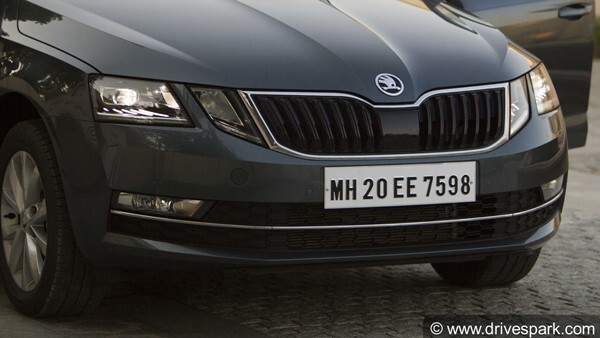

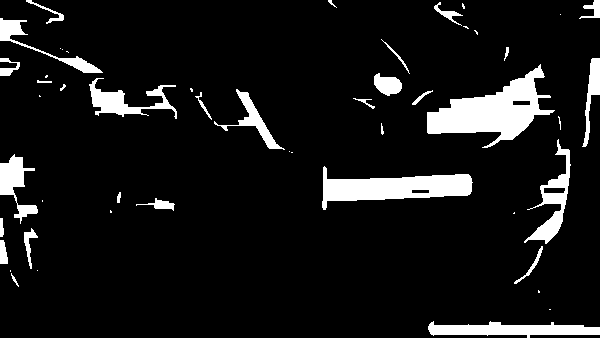

CLEANING PLATE. . .


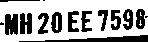

Detected Text :  Mii 20 EE 7598



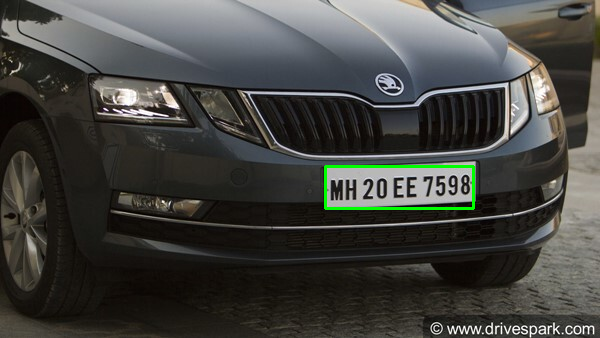

In [14]:
#img = cv2.imread("testData/Final.JPG")

img = cv2.imread("1.jpeg")

threshold_img = preprocess(img)
contours= extract_contours(threshold_img)

cleanAndRead(img,contours)

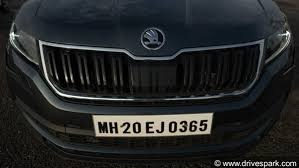

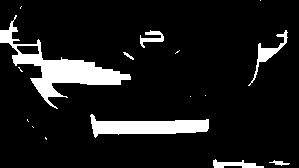

CLEANING PLATE. . .


Detected Text :  WH20EJ0365



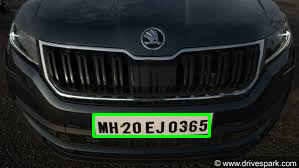

In [23]:
img = cv2.imread("2.jpeg")

threshold_img = preprocess(img)
contours= extract_contours(threshold_img)

cleanAndRead(img,contours)